## Objetivo

Os objetivos desta lista de exercícios são:
 - proporcionar uma vivência prática de processamento de diferentes “sinais” multimídia (áudio e imagens).
 - compreender as características básicas destes sinais;
 - explorar como as emoções podem ser analisadas a partir da modelagem destas características (features);
 - entrar em contato com algumas ferramentas software existentes.


## Atividades selecionadas

###  Atividade 5 (5,0 pontos)
 - Faça o download do corpus disponibilizado no link (link não pode ser compartilhado).
 - Esse corpus contém imagens da face de uma atriz expressando quatro estados emocionais diferentes, além do estado neutro: “joy”, “anger”, “fear”, “sadness”. O arquivo “imagedb_CH_disciplina.csv” associa cada imagem a um rótulo emocional e também a coordenadas de pontos característicos da face. Atenção, este corpus não deve ser compartilhado por estar sujeito a cessão de direitos de uso de voz e imagens especiais. Ao realizar o download do corpus você estará se comprometendo a respeitar os princípios de não-compartilhamento dos dados e de uso exclusivo para fins específicos de estudo e pesquisa no contexto desta disciplina.
 - Implemente um classificador de emoções para esta base, baseado nos pontos característicos da face (“features” geométricos ou de “shape”).
 - Apresente um relatório detalhado desta atividade, esclarecendo a abordagem adotada e os resultados obtidos. Analise e critique os resultados.

### Atividade 6 (5,0 pontos)
 - Acesse o tutorial [Emotion Recognition using Facial Landmarks, Python, DLib and OpenCV](http://www.paulvangent.com/2016/08/05/emotion-recognition-using-facial-land)
 - Execute o tutorial.
 - Crie um relatório do cumprimento da atividade, incluindo imagens e trechos do código desenvolvidos. Relate os principais problemas encontrados e as lições aprendidas. Analise e discuta seus resultados.


## Exercício Resolvido - Atividade 5

Neste notebook será implementado e resolvido a ATIVIDADE 5.

Para a resolução do exercício a **aborgagem sera híbrida**, entretanto serão apresentados os resultados em ambos os casos (tanto geométrico, quanto de textura)

### Instalação OpenCV e DLib

- [opencv-python](https://pypi.org/project/opencv-python/)
- [dlib](https://pypi.org/project/dlib/)
- [dlib - shape_predictor_68_face_landmarks.dat](http://dlib.net/face_landmark_detection.py.html)

In [1]:
# !apt-get install build-essential cmake pkg-config libx11-dev libatlas-base-dev libgtk-3-dev libboost-python-dev
# !pip install dlib
# !pip install numpy scipy pandas matplotlib scikit-learn scikit-image opencv-python opencv-contrib-python

### Import das bibliotecas a serem utilizadas

In [2]:
import math
import os
import glob
from random import choices, shuffle
import pprint
import copy
import csv

import numpy as np
from scipy import fftpack
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import local_binary_pattern
import dlib
import cv2

np.random.seed(0)
np.warnings.filterwarnings('ignore')

%matplotlib inline

pp = pprint.PrettyPrinter(indent=4)

### Carregamento dos classificadores

Para a tarefa em questão, será carregado o *HaarCascade Classifier* da *OpenCV* para a identificação de faces e o face detector e shape landmark da *DLib* que retornará o posicionamento dos principais landmarks de uma face.

<img src="images/landmarks.png" width="200" />

In [3]:
face_cascades = [
    cv2.CascadeClassifier('classifier/haarcascade_frontalface_default.xml'),
    cv2.CascadeClassifier('classifier/haarcascade_frontalface_alt.xml'),
    cv2.CascadeClassifier('classifier/haarcascade_frontalface_alt2.xml'),
    cv2.CascadeClassifier('classifier/haarcascade_frontalface_alt_tree.xml'),
]

# Face detector
detector = dlib.get_frontal_face_detector()
# Landmark identifier. Set the filename to whatever you named the downloaded file
predictor = dlib.shape_predictor('classifier/shape_predictor_68_face_landmarks.dat')

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

sentiments = [('neutral', 'Em6'), ('anger', 'Em22'), ('fear', 'Em13'), ('joy', 'Em2'), ('sadness', 'Em12')]

### Correção de Iuminação

Caso seja utilizado outro tipo de extração de feature de textura, poderia ser realizada uma correção de iluminação, permitindo assim uma melhor distribuição dos tons de cinza dos pixels da imagem.

Como exemplo para essa correção poderia-se utilizar um Low Pass Filter conforme:

$g(x,y) = f(x, y) - LPF(f(x, y)) + mean(LPF(f(x, y)))$

$LPF(x, y) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$

Onde f(x, y) é a imagem que se quer corrigir... seria possível utilizar uma correção gamma, entretanto para isso seria necessário calcular o gamma necessário para a correção.

In [4]:
def normalization(x, m=255):
    return (((x - np.min(x)) / (np.max(x) - np.min(x))) * m).astype('int64')

def gaussian_filter(f):
    c, r = 20, 20

    sigma = .1
    shift_c = int(np.ceil((c / sigma)))
    shift_r = int(np.ceil((r / sigma)))

    x, y = np.meshgrid(np.arange(-r, r, 0.1), np.arange(-c, c, 0.1))
    # Gaussian Filter
    g = (1 / (2 * np.pi * sigma**2)) *  np.exp(-(x**2 + y**2) / (2 * sigma**2))

    F = fftpack.fftn(f)
    G = fftpack.fftn(g, f.shape)
    h = np.real(np.roll(fftpack.ifftn(F * G), (-shift_c, -shift_r), (0, 1)))
    return h

def lux_correction_lpf(image):
    G = gaussian_filter(image)
    return np.asarray(normalization(255 - ((image - G) + np.mean(G))), dtype=np.uint8)

### Apresentação das imagens utilizadas no exercício

Abaixo serão apresentadas algumas das imagens que iremos utilizar no exercício.

Quantidade de Imagens por sentimento: 
--------------------
Neutral :  40
Anger   :  39
Fear    :  40
Joy     :  43
Sadness :  40


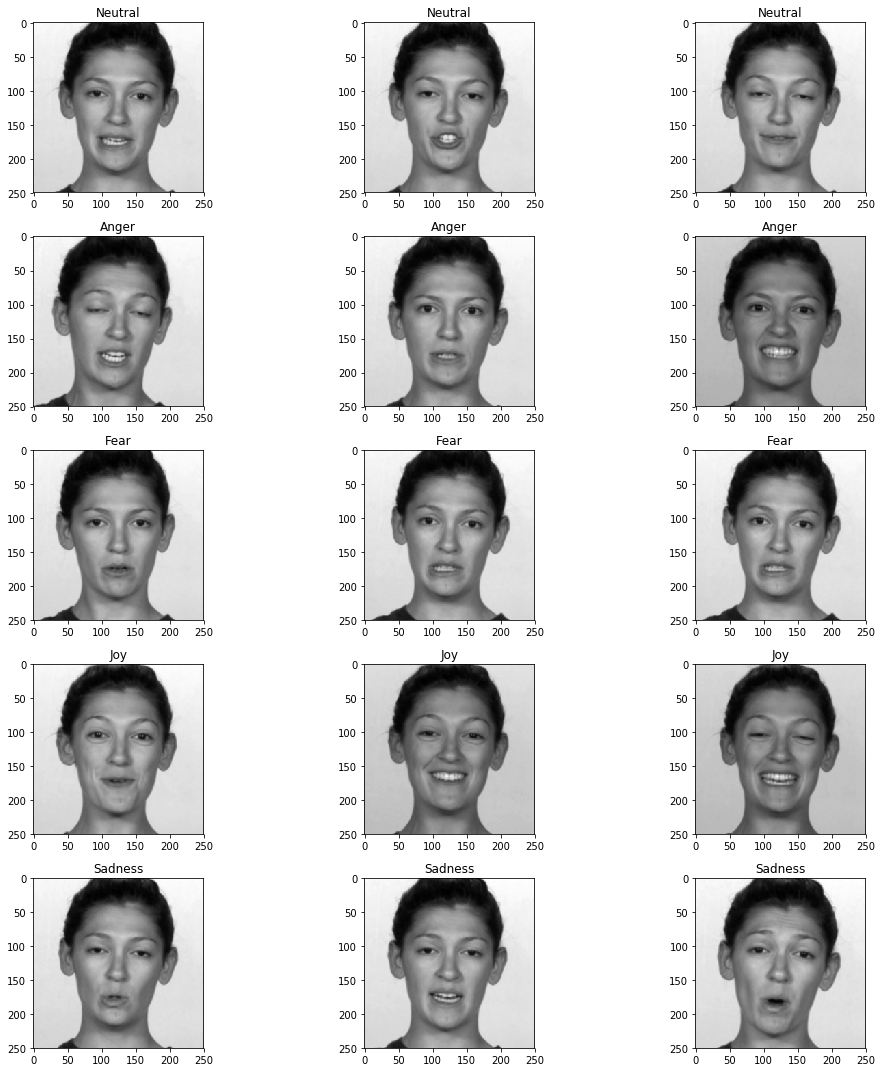

In [141]:
def crop_face(image, M=60):
    # Shape para calcular algumas questões...
    wg, hg = image.shape
    
    # Cortar exatamente a posição da face
    for face_cascade in face_cascades:
        faces = face_cascade.detectMultiScale(image, 1.1, 1, minSize=(15, 15), flags=cv2.CASCADE_SCALE_IMAGE)
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            yM, xM = np.abs(y-M), np.abs(x-M)
            yMh, xMw = np.abs((y+M)+h), np.abs((x+M)+w)
            image = image[yM:yMh, xM:xMw]
            break
    return cv2.resize(image, (250, 250))

# Carregando todos os arquivos
emotions = {sentiment : [] for sentiment, filename in sentiments}
for emotion, filename in sentiments:
    for file in glob.glob(f'Faces_Disciplina/{filename}_*', recursive=True):
        emotions[emotion].append(file)

print('Quantidade de Imagens por sentimento: ')
print('-' * 20)
print('Neutral : ', len(emotions['neutral']))
print('Anger   : ', len(emotions['anger']))
print('Fear    : ', len(emotions['fear']))
print('Joy     : ', len(emotions['joy']))
print('Sadness : ', len(emotions['sadness']))

plt.figure(figsize=(15, 15))
N = 0
for emt in emotions.keys():
    for i in range(N, N + 3):
        ax = plt.subplot(5, 3, i + 1)
        image = cv2.imread(choices(emotions[emt])[0])
        image = crop_face(lux_correction_lpf(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)))
        plt.title(emt.title())
        plt.imshow(image, cmap='gray')
    N += 3
plt.tight_layout()
plt.show()

### Pré-processamento das imagens

O próximo passo é efetivamente realizar o pré-processamento de todas as imagens e retirar delas as features necessárias para nosso classificador.

No exercício, será passado ao classificar um modelo híbrido de features, será extraído tanto features geométricas quanto de textura.

### Extraindo features geométricas

Conforme utilizado na Atividade 6 e disponibilizado no dataset que está em conjunto com as imagens, as features geométricas são extraídas utilizando a ferramenta DLib.

Abaixo esta o código para receber cada imagem e extrair as features geométricas dela.

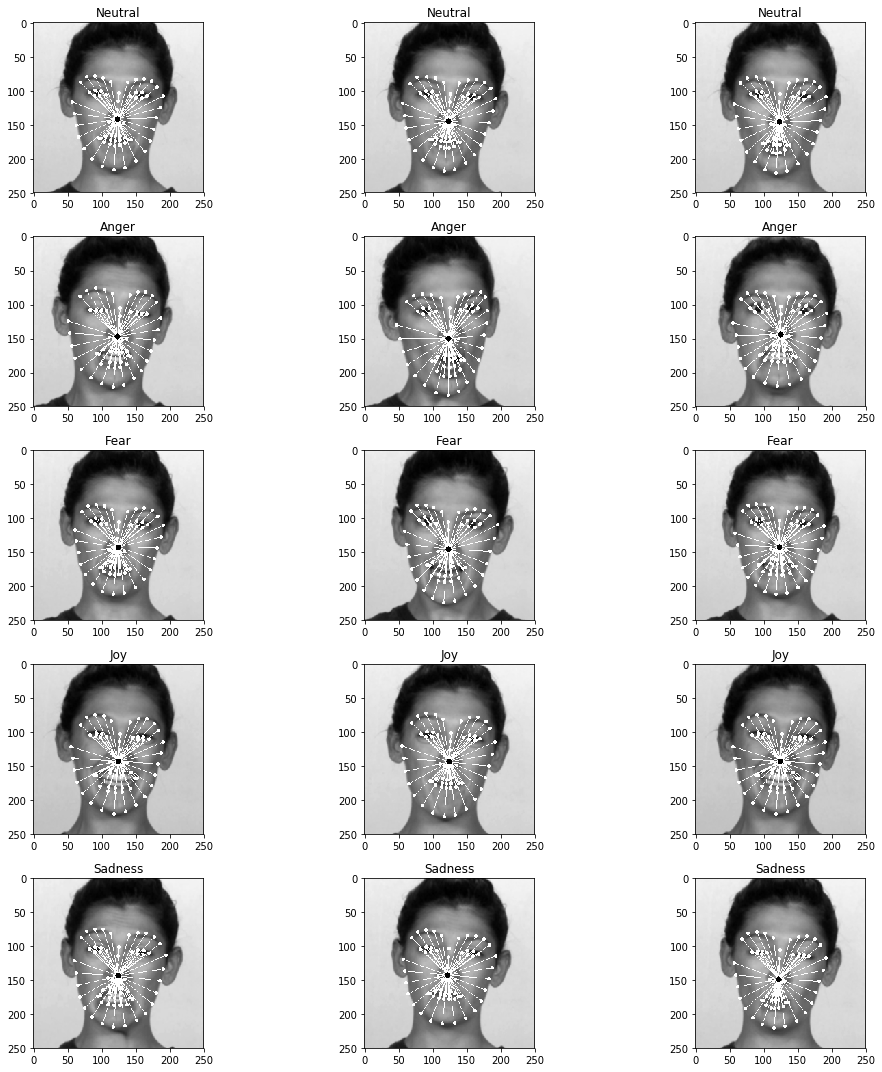

In [6]:
def get_landmarks(image):
    data = {
        'landmarks_vectorised': []
    }
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        landmarks = []
        for i in range(1, 68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
        xmean = np.mean(xlist) #Find both coordinates of centre of gravity
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist] #Calculate distance centre <-> other points in both axes
        ycentral = [(y-ymean) for y in ylist]
        landmarks_vectorised = [xmean, ymean]
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean, xmean))
            coornp = np.asarray((z, w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1:
        data['landmarks_vestorised'] = []
    return data

def get_geometric_data(emotion, image):
    _data, _labels = [], []
    image = crop_face(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY))
    clahe_image = clahe.apply(image)
    data = get_landmarks(clahe_image)
    if len(data['landmarks_vectorised']) > 0:
        _data.append(data['landmarks_vectorised']) #append image array to training data list
        _labels.append(emotion)
    return _data, _labels


# Apresentação das faces usando as funções acima...
plt.figure(figsize=(15, 15))
N = 0
white = (255, 255, 255)
for emt in emotions.keys():
    for i in range(N, N + 3):
        ax = plt.subplot(5, 3, i + 1)
        image = choices(emotions[emt])[0]
        
        _geom, _labels = get_geometric_data(emt, image)
        _geom = _geom[0]
        xmean, ymean = _geom[:2]
        xmean, ymean = int(xmean), int(ymean)
        _geom = _geom[2:]
        landsmk = np.asarray([_geom[i:i+4] for i in range(0, len(_geom), 4)])
        image = cv2.imread(image)
        gray = crop_face(lux_correction_lpf(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)))
        xlist, ylist = [], []
        for landmark in landsmk:
            k, l = int(landmark[0]), int(landmark[1])
            dist = landmark[2]
            ang = landmark[3]
            # Usamos os valores da média, para imprimir a posição dos pontos na imagem.
            xlist += [int(int(xmean) + dist * np.cos(ang * math.pi / 180))]
            ylist += [int(int(ymean) + dist * np.sin(ang * math.pi / 180))]
        for x, y in zip(xlist, ylist):
            cv2.circle(gray, (x, y), 1, white, thickness=2)
            cv2.line(gray, (x, y), (xmean, ymean), white, thickness=1)
        cv2.circle(gray, (xmean, ymean), 1, (0, 0, 0), thickness=5)
        
        plt.title(emt.title())
        plt.imshow(gray, cmap='gray')
    N += 3
plt.tight_layout()
plt.show()

### PCA / t-SNE dos Landmarks

Para exemplificação, será apresentado o PCA / t-SNE dos landmarks coletados.

Importante salientar que é realizado uma normalização para apresentação do PCA / t-SNE.

In [117]:
gpoints = []
gsents = []
for emt in emotions.keys():
    for image in emotions[emt]:
        _geom, _labels = get_geometric_data(emt, image)
        gpoints.append(_geom[0])
        gsents.append(_labels)

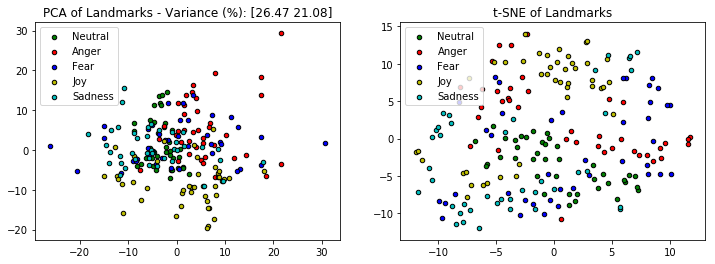

In [118]:
Xg = StandardScaler().fit_transform(gpoints)
pca = PCA(n_components=2)
pog = pca.fit_transform(Xg)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=5, random_state=0)
pog2 = tsne.fit_transform(Xg)

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title(f'PCA of Landmarks - Variance (%): {np.round(pca.explained_variance_ratio_ * 100, 2)}')
plt.scatter(pog[:40, 0], pog[:40, 1], c='g', s=20, edgecolor='k', label='Neutral')
plt.scatter(pog[40:79, 0], pog[40:79, 1], c='r', s=20, edgecolor='k', label='Anger')
plt.scatter(pog[79:119, 0], pog[79:119, 1], c='b', s=20, edgecolor='k', label='Fear')
plt.scatter(pog[119:162, 0], pog[119:162, 1], c='y', s=20, edgecolor='k', label='Joy')
plt.scatter(pog[162:202, 0], pog[162:202, 1], c='c', s=20, edgecolor='k', label='Sadness')
plt.legend()
plt.subplot(1, 2, 2)
plt.title(f't-SNE of Landmarks')
plt.scatter(pog2[:40, 0], pog2[:40, 1], c='g', s=20, edgecolor='k', label='Neutral')
plt.scatter(pog2[40:79, 0], pog2[40:79, 1], c='r', s=20, edgecolor='k', label='Anger')
plt.scatter(pog2[79:119, 0], pog2[79:119, 1], c='b', s=20, edgecolor='k', label='Fear')
plt.scatter(pog2[119:162, 0], pog2[119:162, 1], c='y', s=20, edgecolor='k', label='Joy')
plt.scatter(pog2[162:202, 0], pog2[162:202, 1], c='c', s=20, edgecolor='k', label='Sadness')
plt.legend()
plt.show()

### Extração de features de textura

Como a abordagem apresentada aqui é híbrida, será extraído também das imagens suas features de textura. Será utilizado o algoritmo de [LBP](https://en.wikipedia.org/wiki/Local_binary_patterns) (Local Binary Pattern {conforme visto em aula}), para extração destas features.

Importante também será o recorte das faces, diminuindo assim a quantidade de features de textura a serem processadas.

Umas das vantagens do LBP é ser invariante a iluminação e a translação, desta maneira não será necessário aplicar a correção de iluminação as imagens.

No caso do LBP, as features que são extraídas, são na verdade o histograma normalizado da imagem.

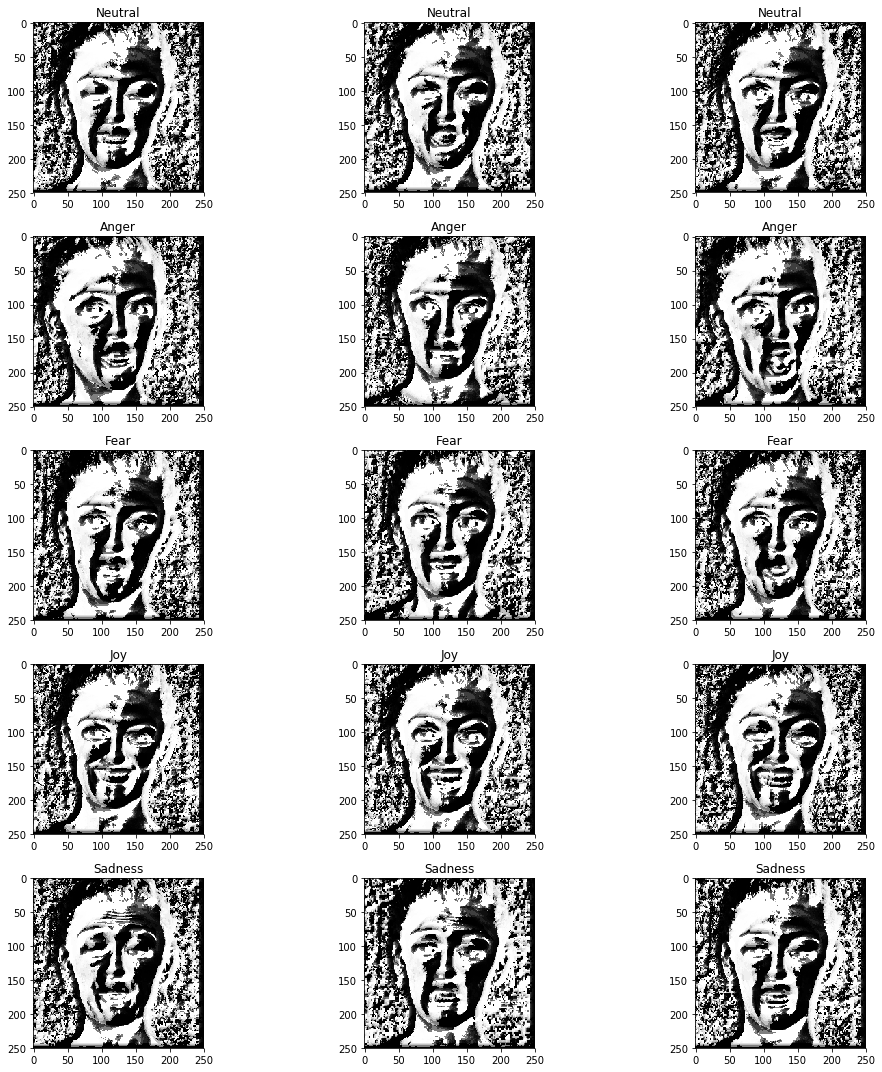

In [89]:
def get_texture_data(image, numPoints=24, radius=8, eps=1e-7):
    image = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(crop_face(image), numPoints, radius)
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
    hist = hist.astype('float')
    # normalizar histogram
    hist /= (hist.sum() + eps)
    return lbp, hist

plt.figure(figsize=(15, 15))
N = 0
for emt in emotions.keys():
    for i in range(N, N + 3):
        ax = plt.subplot(5, 3, i + 1)
        image = choices(emotions[emt])[0]
        lbp, lbph = get_texture_data(image)
        plt.title(emt.title())
        plt.imshow(lbp, cmap='gray')
    N += 3
plt.tight_layout()
plt.show()

### PCA / t-SNE do LBPH

Para exemplificação, será apresentado o PCA / t-SNE das Texturas (LBP - Histograma) coletados.

Importante salientar que é realizado uma normalização para apresentação do PCA / t-SNE.

In [115]:
tpoints = []
tsents = []
for emt in emotions.keys():
    for image in emotions[emt]:
        lbp, lbph = get_texture_data(image)
        tpoints.append(lbph)
        tsents.append(emt)

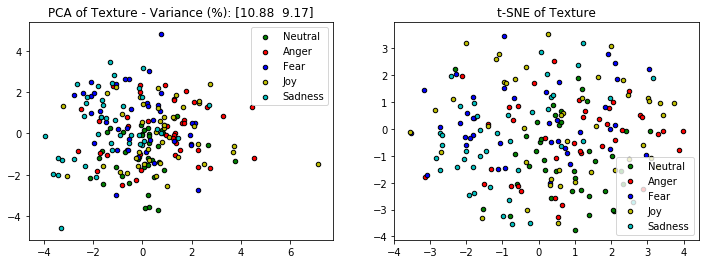

In [116]:
Xt = StandardScaler().fit_transform(tpoints)
pca = PCA(n_components=2)
pot = pca.fit_transform(Xt)
tsne = TSNE(n_components=2, perplexity=50, learning_rate=15, random_state=0)
pot2 = tsne.fit_transform(Xt)

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title(f'PCA of Texture - Variance (%): {np.round(pca.explained_variance_ratio_ * 100, 2)}')
plt.scatter(pot[:40, 0], pot[:40, 1], c='g', s=20, edgecolor='k', label='Neutral')
plt.scatter(pot[40:79, 0], pot[40:79, 1], c='r', s=20, edgecolor='k', label='Anger')
plt.scatter(pot[79:119, 0], pot[79:119, 1], c='b', s=20, edgecolor='k', label='Fear')
plt.scatter(pot[119:162, 0], pot[119:162, 1], c='y', s=20, edgecolor='k', label='Joy')
plt.scatter(pot[162:202, 0], pot[162:202, 1], c='c', s=20, edgecolor='k', label='Sadness')
plt.legend()
plt.subplot(1, 2, 2)
plt.title(f't-SNE of Texture')
plt.scatter(pot2[:40, 0], pot2[:40, 1], c='g', s=20, edgecolor='k', label='Neutral')
plt.scatter(pot2[40:79, 0], pot2[40:79, 1], c='r', s=20, edgecolor='k', label='Anger')
plt.scatter(pot2[79:119, 0], pot2[79:119, 1], c='b', s=20, edgecolor='k', label='Fear')
plt.scatter(pot2[119:162, 0], pot2[119:162, 1], c='y', s=20, edgecolor='k', label='Joy')
plt.scatter(pot2[162:202, 0], pot2[162:202, 1], c='c', s=20, edgecolor='k', label='Sadness')
plt.legend()
plt.show()

In [103]:
gtpoints = []
gtsents = []
for emt in emotions.keys():
    for image in emotions[emt]:
        _geom, _labels = get_geometric_data(emt, image)
        lbp, lbph = get_texture_data(image)
        gtpoints.append(np.append(_geom[0], lbph))
        gtsents.append(_labels)

### PCA / t-SNE do GEOMETRIA + LBPH

Dentro da abordagem proposta sugerida, assim como acima será apresentado o PCA / t-SNE do conjunto de features que compõe geometria + textura.

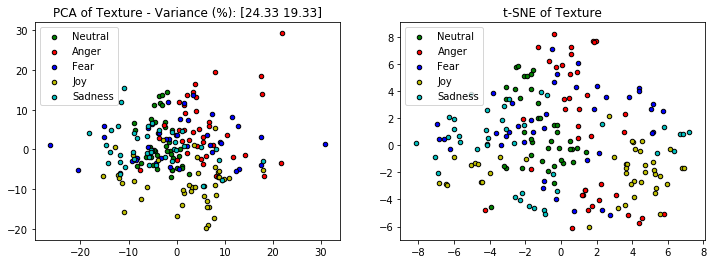

In [113]:
Xgt = StandardScaler().fit_transform(gtpoints)
pca = PCA(n_components=2)
pogt = pca.fit_transform(Xgt)
tsne = TSNE(n_components=2, perplexity=50, learning_rate=17, random_state=0)
pogt2 = tsne.fit_transform(Xgt)

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title(f'PCA of Texture - Variance (%): {np.round(pca.explained_variance_ratio_ * 100, 2)}')
plt.scatter(pogt[:40, 0], pogt[:40, 1], c='g', s=20, edgecolor='k', label='Neutral')
plt.scatter(pogt[40:79, 0], pogt[40:79, 1], c='r', s=20, edgecolor='k', label='Anger')
plt.scatter(pogt[79:119, 0], pogt[79:119, 1], c='b', s=20, edgecolor='k', label='Fear')
plt.scatter(pogt[119:162, 0], pogt[119:162, 1], c='y', s=20, edgecolor='k', label='Joy')
plt.scatter(pogt[162:202, 0], pogt[162:202, 1], c='c', s=20, edgecolor='k', label='Sadness')
plt.legend()
plt.subplot(1, 2, 2)
plt.title(f't-SNE of Texture')
plt.scatter(pogt2[:40, 0], pogt2[:40, 1], c='g', s=20, edgecolor='k', label='Neutral')
plt.scatter(pogt2[40:79, 0], pogt2[40:79, 1], c='r', s=20, edgecolor='k', label='Anger')
plt.scatter(pogt2[79:119, 0], pogt2[79:119, 1], c='b', s=20, edgecolor='k', label='Fear')
plt.scatter(pogt2[119:162, 0], pogt2[119:162, 1], c='y', s=20, edgecolor='k', label='Joy')
plt.scatter(pogt2[162:202, 0], pogt2[162:202, 1], c='c', s=20, edgecolor='k', label='Sadness')
plt.legend()
plt.show()

### Carregamentos das imagens pré-processadas

In [107]:
def get_dataset():
    dataset = []
    data_append = dataset.append
    for emt in emotions.keys():
        for image in emotions[emt]:
            geom, label = get_geometric_data(emt, image)
            lbp, lbph = get_texture_data(image)
            data_append({
                'emotion': emt,
                'filename': image,
                'geom': np.asarray(geom[0]),
                'lbp': np.asarray(lbph)
            })
    return dataset

dataset = get_dataset()

### Classificador

Serão utilizados 4 classificadores para validar as features que foram extraídas das imagens.

 - LinearSVC
 - KNeighborsClassifier
 - DecisionTreeClassifier
 - RandomForestClassifier

Esses classificadores serão utilizados para validar o quão efetivas e diferenças que podem existir nas features para cada classificador.

In [108]:
def make_sets(dataset, data_type='both'):
    shuffle(dataset)
    train_data, train_labels, predict_data, predict_labels = [], [], [], []
    training, prediction = dataset[:int(len(dataset) * 0.7)], dataset[-int(len(dataset)*0.3):]
    # TRAINING DATA
    for train in training:
        if data_type == 'geometric':
            train_data.append(train['geom'])
        elif data_type == 'texture':
            train_data.append(train['lbp'])
        else:
            train_data.append(np.append(train['geom'], train['lbp']))
        train_labels.append(train['emotion'])
    # PREDICTION DATA
    for pred in prediction:
        if data_type == 'geometric':
            predict_data.append(pred['geom'])
        elif data_type == 'texture':
            predict_data.append(pred['lbp'])
        else:
            predict_data.append(np.append(pred['geom'], pred['lbp']))
        predict_labels.append(pred['emotion'])
    
    return np.asarray(train_data, dtype=np.float32), \
            train_labels, \
            np.asarray(predict_data, dtype=np.float32), \
            predict_labels

print('Geometric: ')
print('-' * 40)
td, tl, pd2, pl2 = make_sets(copy.deepcopy(dataset), 'geometric')
dfg = pd.DataFrame(td, index=tl)
display(dfg.head(10))

dfg = pd.DataFrame(pd2, index=pl2)
display(dfg.head(10))

print()
print('Texture: ')
print('-' * 40)
td, tl, pd2, pl2 = make_sets(copy.deepcopy(dataset), 'texture')
dft = pd.DataFrame(td, index=tl)
display(dft.head(10))

dfg = pd.DataFrame(pd2, index=pl2)
display(dfg.head(10))

Geometric: 
----------------------------------------


,0,1,2,3,4,5,6,7,8,9,...,260,261,262,263,264,265,266,267,268,269
neutral,124.641792,142.746262,59.0,121.0,69.150162,-161.670639,62.0,139.0,62.753712,-176.577530,...,32.695774,80.567780,122.0,176.0,33.358501,94.542236,114.0,175.0,33.963966,108.259781
neutral,122.970146,146.223877,54.0,120.0,73.787354,-159.182159,57.0,138.0,66.480774,-172.894135,...,31.840887,86.344925,119.0,179.0,33.015694,96.906555,114.0,178.0,33.017956,105.763954
joy,126.671638,143.955231,52.0,130.0,75.964478,-169.414230,56.0,147.0,70.737198,177.533020,...,31.459606,72.751381,127.0,175.0,31.046513,89.394012,118.0,174.0,31.271168,106.099403
joy,124.791046,143.194031,56.0,123.0,71.693840,-163.640076,59.0,140.0,65.868530,-177.220581,...,40.287296,81.134415,121.0,183.0,39.986088,95.440331,111.0,182.0,41.183689,109.564430
anger,123.253731,148.014923,52.0,126.0,74.577148,-162.830673,54.0,144.0,69.370018,-176.682037,...,38.417255,81.397690,121.0,187.0,39.050163,93.308594,113.0,186.0,39.344692,105.106430
joy,126.029854,143.014923,58.0,123.0,70.913033,-163.605698,61.0,141.0,65.061058,-178.225281,...,34.692482,78.409683,124.0,178.0,35.043911,93.320602,116.0,177.0,35.434208,106.442657
joy,122.805969,144.805969,56.0,120.0,71.262711,-159.629349,59.0,138.0,64.167931,-173.911469,...,32.194614,89.654686,117.0,178.0,33.697968,99.921249,110.0,176.0,33.720325,112.319443
anger,123.955223,150.313431,53.0,128.0,74.380997,-162.543091,57.0,147.0,67.037163,-177.166901,...,35.209335,80.114426,123.0,186.0,35.699348,91.533272,116.0,186.0,36.562504,102.566864
neutral,124.402985,147.507462,57.0,122.0,72.067978,-159.271744,61.0,141.0,63.736061,-174.139877,...,40.752647,83.523087,120.0,189.0,41.725494,96.057281,112.0,187.0,41.394379,107.435364
neutral,124.223877,149.238800,57.0,124.0,71.805626,-159.421646,61.0,142.0,63.636932,-173.468369,...,31.810816,86.799294,121.0,182.0,32.919437,95.620125,116.0,181.0,32.808620,104.516701


,0,1,2,3,4,5,6,7,8,9,...,260,261,262,263,264,265,266,267,268,269
neutral,124.343285,143.522385,59.0,120.0,69.448166,-160.202057,62.0,138.0,62.587395,-174.937927,...,33.799934,82.081001,121.0,178.0,34.639332,95.538635,113.0,177.0,35.347145,108.718018
neutral,123.552238,147.611938,57.0,123.0,70.957367,-159.704910,60.0,142.0,63.799538,-174.953629,...,31.421431,87.359131,120.0,180.0,32.582279,96.259033,115.0,179.0,32.532307,105.241287
fear,125.417908,146.910446,54.0,129.0,73.629494,-165.921509,59.0,148.0,66.426849,179.060181,...,33.737846,78.749718,124.0,181.0,34.119026,92.381767,116.0,180.0,34.403713,105.887352
joy,125.014923,140.910446,58.0,124.0,69.115578,-165.837723,61.0,141.0,64.014992,179.919846,...,38.724735,79.608246,122.0,179.0,38.208687,94.525734,112.0,178.0,39.306782,109.336250
anger,124.447762,147.343277,54.0,124.0,74.214523,-161.667084,56.0,142.0,68.656006,-175.536331,...,32.972473,82.064293,123.0,180.0,32.688793,92.538414,117.0,179.0,32.521023,103.239014
sadness,122.074623,146.507462,57.0,123.0,69.190376,-160.138321,60.0,141.0,62.318466,-174.929810,...,30.553263,86.387001,117.0,178.0,31.898773,99.153809,111.0,176.0,31.503288,110.581459
joy,125.417908,142.910446,59.0,124.0,69.057541,-164.107330,62.0,141.0,63.446678,-178.274506,...,37.669071,79.936783,122.0,182.0,39.238697,94.997116,113.0,181.0,40.062683,108.056946
neutral,124.328362,145.149246,57.0,122.0,71.196877,-161.025681,61.0,140.0,63.537357,-175.351486,...,31.068464,83.212975,121.0,177.0,32.024178,95.965675,114.0,176.0,32.533730,108.509758
joy,124.447762,144.970154,55.0,124.0,72.544739,-163.198013,58.0,142.0,66.514107,-177.440643,...,40.413071,82.103317,121.0,186.0,41.174454,94.803314,112.0,185.0,41.920589,107.273705
anger,122.701492,150.462692,56.0,125.0,71.396339,-159.106094,60.0,144.0,63.033669,-174.115265,...,46.837975,83.504555,119.0,198.0,47.681206,94.452354,110.0,196.0,47.275520,105.585114



Texture: 
----------------------------------------


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
sadness,0.740135,0.062007,0.014092,0.033258,0.025930,0.005073,0.011274,0.022548,0.008455,0.001127,...,0.028185,0.002255,0.000000,0.000564,0.002818,0.000000,0.002255,0.000564,0.012401,0.001127
neutral,0.716667,0.075926,0.016667,0.032099,0.027778,0.004938,0.012346,0.017284,0.010494,0.001235,...,0.029630,0.003704,0.001235,0.001852,0.006173,0.000617,0.000000,0.002469,0.012346,0.001235
fear,0.718994,0.074302,0.016201,0.036872,0.013966,0.002793,0.012291,0.027933,0.011732,0.002235,...,0.023464,0.001676,0.001117,0.001117,0.003352,0.000559,0.000000,0.001676,0.008939,0.004469
anger,0.726875,0.085933,0.008758,0.045977,0.014778,0.004926,0.008758,0.027367,0.010400,0.000547,...,0.019157,0.004379,0.000000,0.000547,0.003284,0.000000,0.000547,0.001095,0.006568,0.000000
anger,0.700341,0.077185,0.015891,0.024972,0.019296,0.006243,0.011918,0.020999,0.014188,0.002270,...,0.038025,0.004540,0.000568,0.001135,0.005675,0.000000,0.000568,0.000568,0.016459,0.004540
fear,0.776256,0.047945,0.011416,0.026826,0.014269,0.002854,0.009132,0.025685,0.006279,0.000571,...,0.023973,0.002283,0.001142,0.001142,0.001142,0.000000,0.001142,0.001712,0.010845,0.000571
sadness,0.739547,0.064987,0.015617,0.026700,0.020655,0.005038,0.007557,0.021159,0.012091,0.004030,...,0.026196,0.002519,0.000000,0.001008,0.003023,0.002519,0.000504,0.000504,0.011083,0.001008
joy,0.712898,0.073394,0.021047,0.041015,0.024285,0.004857,0.010793,0.019428,0.008635,0.001619,...,0.028063,0.005936,0.000540,0.003778,0.002159,0.000000,0.000540,0.001079,0.015650,0.002698
anger,0.732807,0.067080,0.014656,0.034949,0.016347,0.004510,0.011838,0.025366,0.008455,0.000564,...,0.027621,0.002818,0.001127,0.000564,0.000564,0.001691,0.000000,0.001127,0.008455,0.003382
fear,0.704409,0.072645,0.018036,0.027555,0.020040,0.004509,0.011523,0.016533,0.013527,0.004008,...,0.025050,0.011022,0.001503,0.003006,0.004008,0.000501,0.000501,0.002004,0.013026,0.002505


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
joy,0.714286,0.081717,0.014109,0.030570,0.016461,0.007643,0.004115,0.022340,0.010582,0.003527,...,0.030570,0.005291,0.002939,0.002352,0.001764,0.001176,0.002939,0.000000,0.012346,0.002352
neutral,0.675423,0.085231,0.020432,0.043199,0.019264,0.004086,0.012259,0.021016,0.016346,0.002919,...,0.030940,0.002919,0.002335,0.003503,0.004086,0.000000,0.000584,0.001751,0.009924,0.002919
sadness,0.770561,0.064955,0.004715,0.022525,0.022001,0.004191,0.009429,0.018334,0.007858,0.002619,...,0.020430,0.003143,0.000524,0.000000,0.002095,0.000000,0.000524,0.000524,0.008905,0.003667
fear,0.762242,0.052231,0.013602,0.025027,0.024483,0.007073,0.008705,0.018498,0.009793,0.002176,...,0.024483,0.004353,0.000544,0.001632,0.004897,0.001088,0.001632,0.001632,0.009793,0.002720
joy,0.710790,0.066741,0.017798,0.026140,0.022247,0.005562,0.011123,0.023359,0.011123,0.001112,...,0.037820,0.002225,0.001112,0.000556,0.006674,0.000556,0.001112,0.002225,0.011123,0.005006
anger,0.715986,0.064059,0.017574,0.045918,0.022109,0.004535,0.013605,0.023810,0.011338,0.002834,...,0.024376,0.002268,0.000567,0.000567,0.006236,0.000567,0.000000,0.005102,0.009070,0.001134
anger,0.713347,0.080384,0.015167,0.031850,0.027300,0.003033,0.006572,0.018706,0.011122,0.002528,...,0.034884,0.003539,0.001011,0.003539,0.004044,0.000000,0.002022,0.001011,0.005056,0.002528
sadness,0.723950,0.082924,0.014730,0.029460,0.024550,0.006547,0.007092,0.015276,0.010911,0.003819,...,0.033824,0.003273,0.002182,0.000546,0.005456,0.001637,0.002728,0.000546,0.007638,0.004364
sadness,0.719227,0.073245,0.014242,0.034079,0.023906,0.003561,0.011190,0.014751,0.010173,0.001526,...,0.026958,0.004578,0.001017,0.001017,0.002543,0.001017,0.000509,0.001526,0.019329,0.001017
joy,0.700953,0.074762,0.014551,0.030105,0.022579,0.007526,0.007025,0.019568,0.013547,0.001505,...,0.033618,0.003011,0.002007,0.000502,0.003512,0.001505,0.000502,0.003011,0.017060,0.002007


In [109]:
classifiers = [
    SVC(kernel='linear', probability=True, tol=1e-4),
    KNeighborsClassifier(5),
    DecisionTreeClassifier(max_depth=15),
    RandomForestClassifier(max_depth=15, n_estimators=10, max_features=1)
]

def run_classifier(classifier, data_type='both'):
    md = classifier 
    accur_lin = []
    pred_lin = []
    
    print('-' * 50)
    print(f'Running : {md.__class__.__name__}')
    epochs = range(10)
    for i in epochs:
        train_data, train_labels, predict_data, predict_labels = make_sets(copy.deepcopy(dataset), data_type)
        md.fit(train_data, train_labels)
        pred_lin_v = md.score(predict_data, predict_labels)
        pred_lin.append(pred_lin_v * 100)
        accur_lin.append(pred_lin_v)
    print(f'Mean accuracy: {np.round(np.mean(accur_lin) * 100, 2)}%')
    print(f'Min accuracy : {np.round(np.min(accur_lin) * 100, 2)}%')
    print(f'Max accuracy : {np.round(np.max(accur_lin) * 100, 2)}%')
    df = pd.DataFrame(np.asarray([np.round(pred_lin, 2)]), index=['accuracy'], columns=[f'epoch : {i}' for i in epochs])
    display(df)
    
    plt.figure(figsize=(7, 3))
    plt.title('Accuracy')
    plt.plot(np.asarray(pred_lin))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

### Execuçao dos classificadores (GEOMETRIA)

Abaixo, os resultados dos classificadores selecionados, apenas utilizando as features de geometria (landmarks).

--------------------------------------------------
Running : SVC
Mean accuracy: 74.83%
Min accuracy : 66.67%
Max accuracy : 83.33%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,71.67,73.33,66.67,81.67,68.33,75.0,83.33,75.0,73.33,80.0


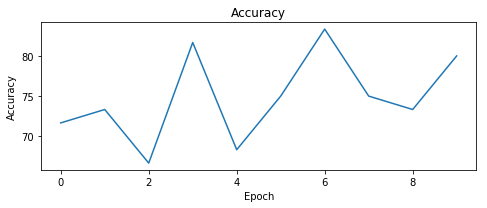

--------------------------------------------------
Running : KNeighborsClassifier
Mean accuracy: 56.67%
Min accuracy : 50.0%
Max accuracy : 63.33%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,56.67,53.33,63.33,56.67,55.0,58.33,55.0,56.67,61.67,50.0


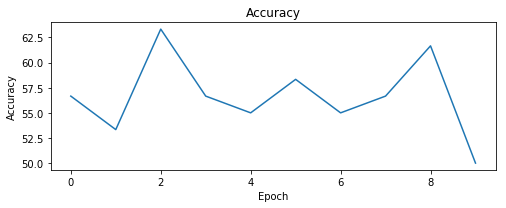

--------------------------------------------------
Running : DecisionTreeClassifier
Mean accuracy: 59.83%
Min accuracy : 51.67%
Max accuracy : 70.0%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,56.67,63.33,60.0,56.67,66.67,53.33,63.33,56.67,70.0,51.67


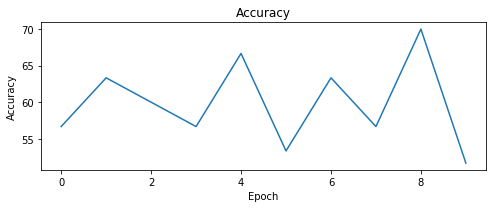

--------------------------------------------------
Running : RandomForestClassifier
Mean accuracy: 63.33%
Min accuracy : 56.67%
Max accuracy : 70.0%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,63.33,56.67,58.33,60.0,70.0,60.0,70.0,65.0,63.33,66.67


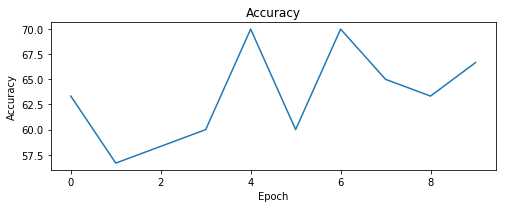

In [121]:
# EXECUTAR OS CLASSIFICADORES E APRESENTAR OS RESULTADOS
for classifier in classifiers:
    run_classifier(classifier, 'geometric')

### Execuçao dos classificadores (TEXTURA)

Abaixo, os resultados dos classificadores selecionados, apenas utilizando as features do histograma de textura (LBPH).

--------------------------------------------------
Running : SVC
Mean accuracy: 16.0%
Min accuracy : 11.67%
Max accuracy : 21.67%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,18.33,15.0,16.67,18.33,11.67,21.67,15.0,13.33,15.0,15.0


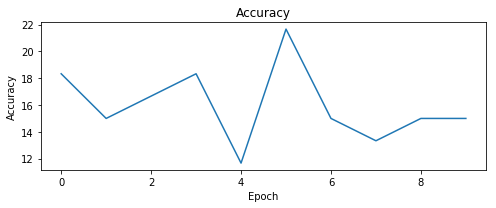

--------------------------------------------------
Running : KNeighborsClassifier
Mean accuracy: 31.67%
Min accuracy : 23.33%
Max accuracy : 38.33%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,38.33,26.67,35.0,23.33,35.0,31.67,28.33,38.33,31.67,28.33


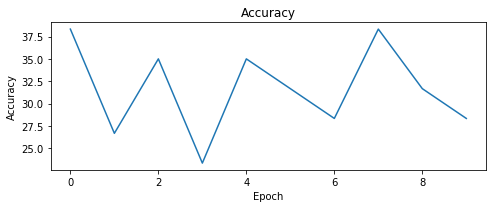

--------------------------------------------------
Running : DecisionTreeClassifier
Mean accuracy: 27.83%
Min accuracy : 18.33%
Max accuracy : 35.0%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,23.33,33.33,31.67,28.33,28.33,28.33,35.0,26.67,18.33,25.0


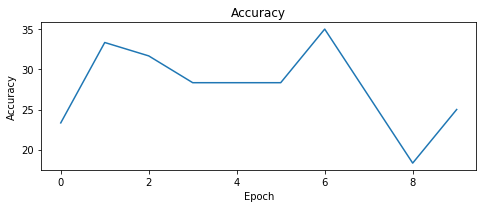

--------------------------------------------------
Running : RandomForestClassifier
Mean accuracy: 27.67%
Min accuracy : 18.33%
Max accuracy : 40.0%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,23.33,25.0,26.67,28.33,35.0,33.33,18.33,26.67,40.0,20.0


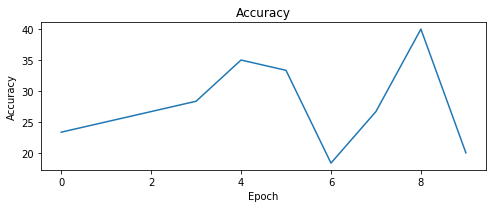

In [140]:
# EXECUTAR OS CLASSIFICADORES E APRESENTAR OS RESULTADOS
for classifier in classifiers:
    run_classifier(classifier, 'texture')

### Execuçao dos classificadores (GEOMETRIA + TEXTURA)

Abaixo, os resultados dos classificadores selecionados, apenas utilizando as features de geometria + textura (LBPH).

--------------------------------------------------
Running : SVC
Mean accuracy: 74.5%
Min accuracy : 68.33%
Max accuracy : 83.33%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,68.33,68.33,75.0,71.67,70.0,73.33,81.67,83.33,71.67,81.67


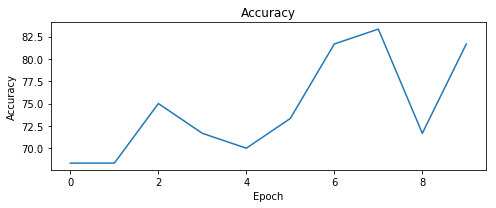

--------------------------------------------------
Running : KNeighborsClassifier
Mean accuracy: 52.5%
Min accuracy : 45.0%
Max accuracy : 65.0%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,58.33,45.0,48.33,56.67,48.33,56.67,48.33,45.0,65.0,53.33


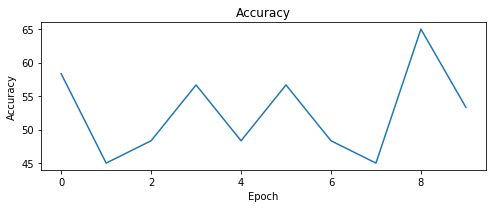

--------------------------------------------------
Running : DecisionTreeClassifier
Mean accuracy: 53.17%
Min accuracy : 43.33%
Max accuracy : 60.0%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,53.33,58.33,53.33,50.0,60.0,55.0,53.33,46.67,43.33,58.33


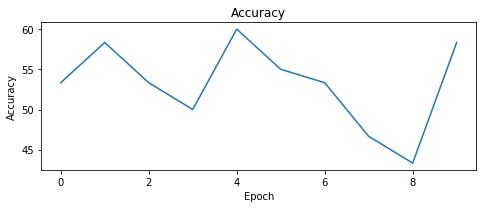

--------------------------------------------------
Running : RandomForestClassifier
Mean accuracy: 57.17%
Min accuracy : 50.0%
Max accuracy : 65.0%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,51.67,50.0,58.33,56.67,65.0,58.33,65.0,55.0,51.67,60.0


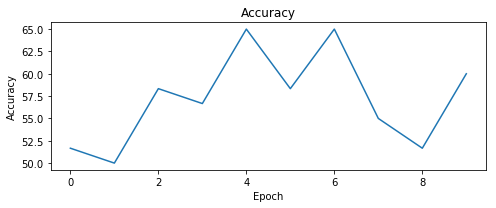

In [133]:
# EXECUTAR OS CLASSIFICADORES E APRESENTAR OS RESULTADOS
for classifier in classifiers:
    run_classifier(classifier)

### Utilizando pontos existentes

Como método de comparação tambem serão carregados todos os pontos deste dataset de imagens os quais vêem em um arquivo csv em conjunto.

In [134]:
# Criacao do dataset com os pontos
dataset_2 = []
dataset_2_append = dataset_2.append
with open('Faces_Disciplina/imagedb_CH_disciplina.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        for sentiment, f in sentiments:
            if row[1] in sentiment:
                lands = []
                for landmark in row[9:]:
                    lnd = np.asarray(landmark.replace('(', '').replace(')', '').split(';'), dtype=np.float32)
                    for l in lnd:
                        lands.append(float(l))
                # lands = np.asarray(lands)
                dataset_2_append([row[0]] + [row[1]] + lands)
dataset_2 = pd.DataFrame(dataset_2, columns=['filename', 'sentiment'] + [f'p{i}' for i in range(112)])
display(dataset_2.head(8))

,filename,sentiment,p0,p1,p2,p3,p4,p5,p6,p7,...,p102,p103,p104,p105,p106,p107,p108,p109,p110,p111
0,Em22_Fala1_0049_640x480.png,anger,302.0,328.0,370.5,331.5,340.0,315.5,337.5,368.0,...,316.5,356.0,338.5,322.5,337.5,358.0,359.5,323.0,357.5,351.0
1,Em22_Fala3_0041_640x480.png,anger,333.5,340.5,386.5,337.0,365.0,312.0,361.0,372.5,...,345.0,350.0,362.5,322.0,361.5,356.5,375.0,323.0,376.0,343.0
2,Em22_Fala1_0165_640x480.png,anger,297.5,308.0,373.0,311.5,339.0,295.0,336.5,340.5,...,316.0,327.5,337.0,300.5,336.5,332.0,357.0,303.0,357.5,328.5
3,Em22_Fala2_0166_640x480.png,anger,309.0,322.0,383.5,325.0,355.5,307.0,352.0,355.0,...,331.0,344.5,353.5,315.5,351.5,346.0,371.5,318.0,370.5,339.5
4,Em22_Fala3_0292_640x480.png,anger,317.0,331.5,381.0,333.0,352.5,319.0,350.0,358.5,...,331.0,342.5,350.5,327.0,350.5,346.0,369.5,329.0,369.5,338.5
5,Em22_Fala3_0346_640x480.png,anger,309.0,317.0,371.0,319.5,342.0,309.0,341.0,330.5,...,323.5,318.0,341.5,314.5,341.5,319.5,356.0,316.0,356.0,317.5
6,Em22_Fala1_0085_640x480.png,anger,305.0,324.5,367.0,327.5,338.5,307.0,337.0,354.5,...,318.0,334.5,339.0,314.5,337.5,341.0,356.0,319.5,356.0,336.5
7,Em22_Fala1_0040_640x480.png,anger,307.5,314.5,370.0,318.5,345.0,300.0,340.0,341.0,...,324.0,320.0,343.0,307.0,340.0,326.5,358.5,312.5,358.5,322.5


### Apresentação dos pontos acima sobrepostos nas imagens

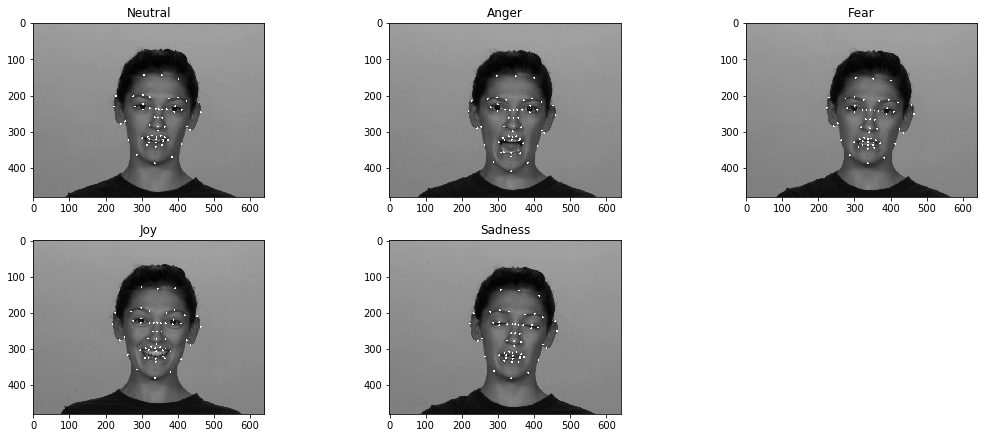

In [135]:
# Apresentação das faces usando as coordenadas existentes no arquivo que acompanha o dataset
plt.figure(figsize=(15, 15))
N = 0
white = (255, 255, 255)
for emt in emotions.keys():
    for i in range(N, N + 1):
        ax = plt.subplot(5, 3, i + 1)
        dt = dataset_2[dataset_2['sentiment'] == emt].iloc[0]
        image = cv2.cvtColor(cv2.imread(f'Faces_Disciplina/{dt["filename"]}'), cv2.COLOR_BGR2GRAY)
        _geom = dt.loc['p0':]
        landsmk = np.asarray([_geom[i:i+2] for i in range(0, len(_geom), 2)])
        for x, y in landsmk:
            cv2.circle(image, (int(x), int(y)), 1, white, thickness=2)
        plt.title(emt.title())
        plt.imshow(image, cmap='gray')
    N += 1
plt.tight_layout()
plt.show()

### PCA  / t-SNE

Conforme outros pontos neste documento, apresenta-se o PCA / t-SNE da distribuição destes pontos.

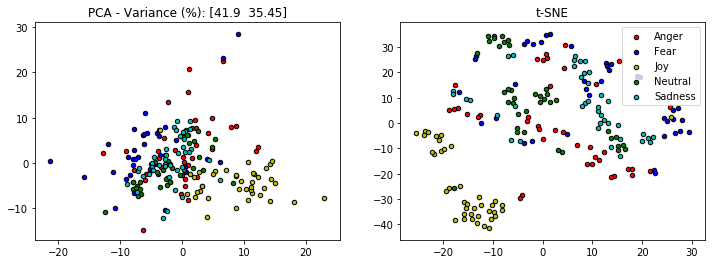

In [136]:
cpoints = dataset_2.loc[:, 'p0':]
csents = dataset_2.loc[:, 'sentiment']

Xc = StandardScaler().fit_transform(cpoints)
pca = PCA(n_components=2)
poc = pca.fit_transform(Xc)
tsne = TSNE(n_components=2, perplexity=10, n_iter=1200, learning_rate=10, random_state=0)
poc2 = tsne.fit_transform(Xc)

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title(f'PCA - Variance (%): {np.round(pca.explained_variance_ratio_ * 100, 2)}')
plt.scatter(poc[:39, 0], poc[:39, 1], c='r', s=20, edgecolor='k', label='Anger')
plt.scatter(poc[39:77, 0], poc[39:77, 1], c='b', s=20, edgecolor='k', label='Fear')
plt.scatter(poc[77:116, 0], poc[77:116, 1], c='y', s=20, edgecolor='k', label='Joy')
plt.scatter(poc[116:155, 0], poc[116:155, 1], c='g', s=20, edgecolor='k', label='Neutral')
plt.scatter(poc[155:, 0], poc[155:, 1], c='c', s=20, edgecolor='k', label='Sadness')
plt.subplot(1, 2, 2)
plt.title(f't-SNE')
plt.scatter(poc2[:39, 0], poc2[:39, 1], c='r', s=20, edgecolor='k', label='Anger')
plt.scatter(poc2[39:77, 0], poc2[39:77, 1], c='b', s=20, edgecolor='k', label='Fear')
plt.scatter(poc2[77:116, 0], poc2[77:116, 1], c='y', s=20, edgecolor='k', label='Joy')
plt.scatter(poc2[116:155, 0], poc2[116:155, 1], c='g', s=20, edgecolor='k', label='Neutral')
plt.scatter(poc2[155:, 0], poc2[155:, 1], c='c', s=20, edgecolor='k', label='Sadness')
plt.legend()
plt.show()

In [137]:
def make_sets_2(dataset):
    data = np.random.rand(len(dataset)) < 0.75
    training = dataset[data]
    prediction = dataset[~data]
    train_data = training.loc[:, 'p0':]
    train_labels = training.loc[:, 'sentiment']
    predict_data = prediction.loc[:, 'p0':]
    predict_labels = prediction.loc[:, 'sentiment']
    return np.asarray(train_data), \
            np.asarray(train_labels), \
            np.asarray(predict_data), \
            np.asarray(predict_labels)

def run_classifier_2(classifier, data_type='both'):
    md = classifier 
    accur_lin = []
    pred_lin = []
    
    print('-' * 50)
    print(f'Running : {md.__class__.__name__}')
    epochs = range(10)
    for i in epochs:
        train_data, train_labels, predict_data, predict_labels = make_sets_2(copy.deepcopy(dataset_2))
        md.fit(train_data, train_labels)
        pred_lin_v = md.score(predict_data, predict_labels)
        pred_lin.append(pred_lin_v * 100)
        accur_lin.append(pred_lin_v)
    print(f'Mean accuracy: {np.round(np.mean(accur_lin) * 100, 2)}%') #FGet mean accuracy of the 10 runs
    print(f'Min accuracy : {np.round(np.min(accur_lin) * 100, 2)}%')
    print(f'Max accuracy : {np.round(np.max(accur_lin) * 100, 2)}%')
    df = pd.DataFrame(np.asarray([np.round(pred_lin, 2)]), index=['accuracy'], columns=[f'epoch : {i}' for i in epochs])
    display(df)
    
    plt.figure(figsize=(7, 3))
    plt.title('Accuracy')
    plt.plot(np.asarray(pred_lin))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

### Classificadores nos pontos existentes

--------------------------------------------------
Running : SVC
Mean accuracy: 89.9%
Min accuracy : 85.42%
Max accuracy : 97.06%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,88.1,85.42,90.38,89.8,88.89,89.23,90.24,97.06,93.62,86.27


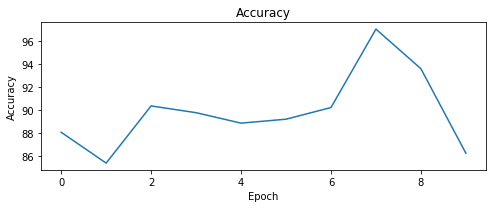

--------------------------------------------------
Running : KNeighborsClassifier
Mean accuracy: 74.55%
Min accuracy : 56.86%
Max accuracy : 82.93%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,75.86,72.73,80.0,78.57,71.93,66.67,56.86,80.43,82.93,79.55


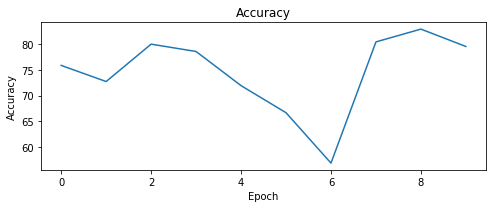

--------------------------------------------------
Running : DecisionTreeClassifier
Mean accuracy: 74.65%
Min accuracy : 63.27%
Max accuracy : 83.33%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,75.0,71.74,63.27,80.49,78.72,73.91,83.33,69.05,76.0,75.0


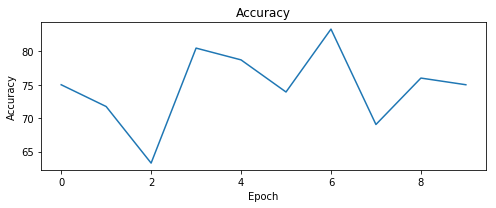

--------------------------------------------------
Running : RandomForestClassifier
Mean accuracy: 71.4%
Min accuracy : 57.14%
Max accuracy : 84.62%


,epoch : 0,epoch : 1,epoch : 2,epoch : 3,epoch : 4,epoch : 5,epoch : 6,epoch : 7,epoch : 8,epoch : 9
accuracy,72.73,60.87,75.51,76.36,76.0,84.62,57.14,69.81,68.42,72.55


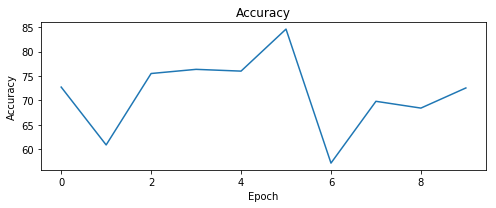

In [139]:
# EXECUTAR OS CLASSIFICADORES E APRESENTAR OS RESULTADOS
for classifier in classifiers:
    run_classifier_2(classifier)

### Considerações Finais

Neste documento, foi apresentado dois tipos de extração de features que podem ser utilizadas para identificar emoção em imagens.

A primeira extração de feature é encontrar os principais pontos faciais (landmarks), que representam a estrutura geométrica da imagem.

A segunda extração denominada LBPH (Local Binary Pattern Histograms) utiliza-se do histograma da imagem após a aplicação do LBP o qual irá representar as feauteres em termos da textura da imagem.

O primeiro método apresentou resultados razoáveis em relação ao segundo, durante o treinamento do algoritmo SVM. Foi realizado outro teste passando ao SVM as features de ambos os métodos, foi percebido apenas uma pequena melhora em alguns casos, entretanto, foi notado uma maior dispersão dos dados neste caso.

Foram também testados 4 algoritmo de Machine Learning, para cada caso, foram avaliados os resultados, e aparentemente as features geométricas tiveram melhores resultados utilizando SVM. Já para as features de textura, RandomFlorest obteve melhores resultados.

Apesar da tentativa híbrida, foi realizado também um teste utilizando os dados providos, estes dados no formato csv. No treinamento do SVM com estes dados, apresentou resultados bem interessantes. Isso pode apresentar a necessidade de uma melhor avaliação das features geradas através dos dois métodos apresentados, tentando trazer uma abordagem híbrida ao reconhecimento facial.

Como futura implementação cabe:

 - Avaliar melhor a geração das features, principalmente a gerada via LBPH;
 - Tentar outro algoritmo de extração de features (textura) para a abordagem híbrida;
 - Utilizar outros algoritmos de Machine Learning e/ou avaliar os parâmetros passados para melhorar / avaliar a acurácia.

### Citação

[OpenCV Gamma Correction](https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/)

 - Rosebrock, A. (2015). OpenCV Gamma Correction. Blog

[Local Binary Patterns with Python & OpenCV](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/)

 - Rosebrock, A. (2015). Local Binary Patterns with Python & OpenCV. Blog

[Texture Matching using Local Binary Patterns (LBP), OpenCV, scikit-learn and Python](http://hanzratech.in/2015/05/30/local-binary-patterns.html)

 - Hanzra, B.S. (2015). Texture Matching using Local Binary Patterns (LBP), OpenCV, scikit-learn and Python.


[Tutorial: Illumination Correction](https://clouard.users.greyc.fr/Pantheon/experiments/illumination-correction/index-en.html)

 - Clouard, R. (2011). Tutorial: Illumination Correction.
 
 